In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install -q opencv-python-headless==4.9.0.80
!pip install -q ultralytics==8.0.149 torchcam albumentations==1.3.0


In [5]:
import ultralytics, torchcam, albumentations, cv2
print("✅ All main packages imported successfully")


✅ All main packages imported successfully


In [6]:
import os
base = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"
for dirname, _, filenames in os.walk(base):
    print(dirname, len(filenames))
    for f in filenames[:10]:
        print("  ", f)
    break


/kaggle/input/vinbigdata-chest-xray-abnormalities-detection 2
   sample_submission.csv
   train.csv


In [7]:
import pandas as pd, numpy as np
ann_path = os.path.join(base, "train.csv")
df = pd.read_csv(ann_path)
print("Rows (boxes):", len(df))
print("Unique images:", df["image_id"].nunique())
classes = sorted(df["class_name"].unique())
print("Classes:", classes)
display(df.head())
display(df.groupby("class_name").size().sort_values(ascending=False).rename("count").to_frame())


Rows (boxes): 67914
Unique images: 15000
Classes: ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


,count
class_name,
No finding,31818
Aortic enlargement,7162
Cardiomegaly,5427
Pleural thickening,4842
Pulmonary fibrosis,4655
Nodule/Mass,2580
Lung Opacity,2483
Pleural effusion,2476
Other lesion,2203


In [8]:
import shutil, os
IMG_SRC = os.path.join(base, "train")   # images folder in dataset
IMG_DST = "/kaggle/working/images_all"
os.makedirs(IMG_DST, exist_ok=True)
SUBSET = False        # set True for quick iteration
MAX_IMAGES = 2000

image_ids = sorted(df["image_id"].unique())
if SUBSET:
    image_ids = image_ids[:MAX_IMAGES]

copied = 0
for img_id in image_ids:
    src = os.path.join(IMG_SRC, f"{img_id}.jpg")
    dst = os.path.join(IMG_DST, f"{img_id}.jpg")
    if os.path.exists(src):
        shutil.copy(src, dst)
        copied += 1
print("Copied images:", copied, "to", IMG_DST)


Copied images: 0 to /kaggle/working/images_all


In [9]:
from pathlib import Path
from PIL import Image
lab_out = "/kaggle/working/labels_all"
os.makedirs(lab_out, exist_ok=True)

class_names = sorted(df["class_name"].unique())
cls2id = {c:i for i,c in enumerate(class_names)}
print("class mapping sample:", list(cls2id.items())[:8])

groups = df.groupby("image_id")
written = 0
for img_id, g in groups:
    img_path = os.path.join(IMG_DST, f"{img_id}.jpg")
    if not os.path.exists(img_path):
        continue
    w, h = Image.open(img_path).size
    lines = []
    for _, row in g.iterrows():
        x_min = row["x_min"]; y_min = row["y_min"]
        bw = row["width"]; bh = row["height"]
        x_c = (x_min + bw/2.0) / w
        y_c = (y_min + bh/2.0) / h
        w_n = bw / w; h_n = bh / h
        cls_id = cls2id[row["class_name"]]
        lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")
    if lines:
        with open(os.path.join(lab_out, f"{img_id}.txt"), "w") as f:
            f.write("\n".join(lines))
        written += 1
print("Label files written:", written, "to", lab_out)

# Save class names for reference
with open("/kaggle/working/classes.txt", "w") as f:
    f.write("\n".join(class_names))


class mapping sample: [('Aortic enlargement', 0), ('Atelectasis', 1), ('Calcification', 2), ('Cardiomegaly', 3), ('Consolidation', 4), ('ILD', 5), ('Infiltration', 6), ('Lung Opacity', 7)]
Label files written: 0 to /kaggle/working/labels_all


In [10]:
import random
random.seed(42)
from pathlib import Path
img_list = sorted([p.stem for p in Path(IMG_DST).glob("*.jpg")])
random.shuffle(img_list)
n = len(img_list)
ntrain = int(0.7 * n)
nval = int(0.15 * n)
train_ids = img_list[:ntrain]
val_ids = img_list[ntrain:ntrain+nval]
test_ids = img_list[ntrain+nval:]

for split, ids in [("train", train_ids), ("val", val_ids), ("test", test_ids)]:
    imdir = f"/kaggle/working/images/{split}"
    lbdir = f"/kaggle/working/labels/{split}"
    os.makedirs(imdir, exist_ok=True)
    os.makedirs(lbdir, exist_ok=True)
    for img_id in ids:
        src_img = os.path.join(IMG_DST, f"{img_id}.jpg")
        dst_img = os.path.join(imdir, f"{img_id}.jpg")
        if os.path.exists(src_img):
            shutil.copy(src_img, dst_img)
        src_lb = os.path.join(lab_out, f"{img_id}.txt")
        dst_lb = os.path.join(lbdir, f"{img_id}.txt")
        if os.path.exists(src_lb):
            shutil.copy(src_lb, dst_lb)

print("train/val/test counts:", len(train_ids), len(val_ids), len(test_ids))

# write dataset.yaml for ultralytics
import yaml
dataset_yaml = {
    "path": "/kaggle/working",
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": {i: n for i,n in enumerate(class_names)}
}
with open("/kaggle/working/dataset.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)
print("Wrote /kaggle/working/dataset.yaml")


train/val/test counts: 0 0 0
Wrote /kaggle/working/dataset.yaml


In [12]:
import os, glob, pprint

print("IMG_SRC (original input):", "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train")
print("IMG_DST (copied):", "/kaggle/working/images_all")
print("Labels all:", "/kaggle/working/labels_all")
print("Train images folder:", "/kaggle/working/images/train")
print("Train labels folder:", "/kaggle/working/labels/train")
print()

def show_counts(path, pattern="*.jpg"):
    if not os.path.exists(path):
        print(f"  {path} -> DOES NOT EXIST")
        return 0
    cnt = len(glob.glob(os.path.join(path, pattern)))
    print(f"  {path} -> {cnt}")
    return cnt

show_counts("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train", "*.jpg")
show_counts("/kaggle/working/images_all", "*.jpg")
show_counts("/kaggle/working/labels_all", "*.txt")
show_counts("/kaggle/working/images/train", "*.jpg")
show_counts("/kaggle/working/labels/train", "*.txt")
show_counts("/kaggle/working/images/val", "*.jpg")
show_counts("/kaggle/working/labels/val", "*.txt")
show_counts("/kaggle/working/images/test", "*.jpg")
show_counts("/kaggle/working/labels/test", "*.txt")

# Print a few file names from each place to inspect
print("\nSample files (up to 10):")
for p in ["/kaggle/working/images_all", "/kaggle/working/labels_all", "/kaggle/working/images/train"]:
    if os.path.exists(p):
        print(f"\n{p}:")
        for f in sorted(os.listdir(p))[:10]:
            print("  ", f)
    else:
        print(f"\n{p}: DOES NOT EXIST")


IMG_SRC (original input): /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train
IMG_DST (copied): /kaggle/working/images_all
Labels all: /kaggle/working/labels_all
Train images folder: /kaggle/working/images/train
Train labels folder: /kaggle/working/labels/train

  /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train -> 0
  /kaggle/working/images_all -> 0
  /kaggle/working/labels_all -> 0
  /kaggle/working/images/train -> 0
  /kaggle/working/labels/train -> 0
  /kaggle/working/images/val -> 0
  /kaggle/working/labels/val -> 0
  /kaggle/working/images/test -> 0
  /kaggle/working/labels/test -> 0

Sample files (up to 10):

/kaggle/working/images_all:

/kaggle/working/labels_all:

/kaggle/working/images/train:


In [16]:
# Cell A: Convert DICOM -> PNG
import os, pathlib, pydicom, numpy as np, cv2, tqdm, shutil

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
DST = "/kaggle/working/images_all"
os.makedirs(DST, exist_ok=True)

SUBSET = True   # set False to convert ALL images (15000). True for debug.
MAX_IMAGES = 3000  # when subset True, convert up to this many

all_dcmins = sorted([str(p) for p in pathlib.Path(SRC).glob("*.dicom")] + [str(p) for p in pathlib.Path(SRC).glob("*.dcm")])
print("Found DICOMs:", len(all_dcmins))
if SUBSET:
    all_dcmins = all_dcmins[:MAX_IMAGES]
    print("Using subset, converting:", len(all_dcmins))

def read_dicom_to_np(path):
    try:
        ds = pydicom.dcmread(path)
        arr = ds.pixel_array.astype(np.float32)
        # PhotometricInterpretation handling
        if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
            arr = arr.max() - arr
        # Some DICOMs have rescale intercept & slope
        intercept = getattr(ds, "RescaleIntercept", 0.0)
        slope = getattr(ds, "RescaleSlope", 1.0)
        arr = arr * slope + intercept
        return arr
    except Exception as e:
        print("Failed read:", path, e)
        return None

def normalize_to_uint8(img):
    # Clip extreme percentiles to reduce outliers then scale
    p1, p99 = np.percentile(img, (1, 99))
    img = np.clip(img, p1, p99)
    img = img - img.min()
    if img.max() > 0:
        img = img / img.max()
    img_u8 = (img * 255.0).astype(np.uint8)
    return img_u8

count = 0
for dpath in tqdm.tqdm(all_dcmins):
    arr = read_dicom_to_np(dpath)
    if arr is None:
        continue
    img = normalize_to_uint8(arr)
    # resize long edge to 1024 for storage (optional)
    h,w = img.shape[:2]
    max_edge = 1024
    if max(h,w) > max_edge:
        scale = max_edge / max(h,w)
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    # save as jpg
    out_name = os.path.splitext(os.path.basename(dpath))[0] + ".jpg"
    out_path = os.path.join(DST, out_name)
    cv2.imwrite(out_path, img)
    count += 1

print("Converted images saved to:", DST, "total:", count)


Found DICOMs: 15000
Using subset, converting: 3000


100%|██████████| 3000/3000 [55:31<00:00,  1.11s/it]  

Converted images saved to: /kaggle/working/images_all total: 3000


In [3]:
# Diagnostic: try reading some DICOMs and writing one JPG
import os, pathlib, traceback
import pydicom, numpy as np, cv2

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
files = sorted([str(p) for p in pathlib.Path(SRC).glob("*")])[:20]
print("First files (up to 20) in train folder (showing names and sizes):")
for f in files[:20]:
    try:
        print(" ", os.path.basename(f), "-", os.path.getsize(f), "bytes")
    except Exception as e:
        print(" ", os.path.basename(f), "- size error:", e)

print("\nAttempt to read up to 5 DICOM files and inspect pixel data:")
count = 0
for f in files:
    if count >= 5:
        break
    try:
        ds = pydicom.dcmread(f, force=True)
        print(f"\nFile: {os.path.basename(f)}")
        # print some header info if present
        for tag in ["PatientID", "StudyInstanceUID", "SeriesInstanceUID", "Rows", "Columns", "PhotometricInterpretation", "BitsAllocated", "BitsStored", "PixelRepresentation"]:
            try:
                val = getattr(ds, tag)
            except Exception:
                val = None
            print("  ", tag, "=", val)
        # try to access pixel_array
        try:
            arr = ds.pixel_array
            print("  pixel_array shape:", getattr(arr, "shape", None), "dtype:", getattr(arr, "dtype", None))
            # basic normalization test
            arrf = arr.astype("float32")
            p1, p99 = np.percentile(arrf, (1,99))
            arrf = np.clip(arrf, p1, p99)
            arrf = arrf - arrf.min()
            if arrf.max() > 0:
                arrf = (arrf / arrf.max() * 255.0).astype("uint8")
            else:
                arrf = arrf.astype("uint8")
            out_path = f"/kaggle/working/tmp_test_{count}.jpg"
            cv2.imwrite(out_path, arrf)
            print("  wrote test jpg:", out_path, "size:", os.path.getsize(out_path))
        except Exception as e:
            print("  could not access pixel_array or write jpg. Exception:")
            traceback.print_exc()
    except Exception as e:
        print("\nFailed to read DICOM:", f)
        traceback.print_exc()
    count += 1

print("\nDiagnostic complete. Check /kaggle/working for tmp_test_*.jpg files.")
print("Listing /kaggle/working jpgs:")
import glob
print(glob.glob("/kaggle/working/tmp_test_*.jpg"))


First files (up to 20) in train folder (showing names and sizes):
  000434271f63a053c4128a0ba6352c7f.dicom - 13250272 bytes
  00053190460d56c53cc3e57321387478.dicom - 9691322 bytes
  0005e8e3701dfb1dd93d53e2ff537b6e.dicom - 18874874 bytes
  0006e0a85696f6bb578e84fafa9a5607.dicom - 8021776 bytes
  0007d316f756b3fa0baea2ff514ce945.dicom - 13271518 bytes
  000ae00eb3942d27e0b97903dd563a6e.dicom - 18874882 bytes
  000d68e42b71d3eac10ccc077aba07c1.dicom - 6609510 bytes
  00150343289f317a0ad5629d5b7d9ef9.dicom - 12665874 bytes
  00176f7e1b1cb835123f95960b9a9efd.dicom - 16750760 bytes
  001d127bad87592efe45a5c7678f8b8d.dicom - 18874874 bytes
  0021df30f3fddef551eb3df4354b1d06.dicom - 18874874 bytes
  00291f7aff0123ea76a59998effef229.dicom - 18874874 bytes
  0032c6091dc8f1b1245fc2f5f45458fa.dicom - 6639402 bytes
  003cfe5ce5c0ec5163138eb3b740e328.dicom - 9691322 bytes
  0046f681f078851293c4e710c4466058.dicom - 6790470 bytes
  004d2bc2111d639f5e8441ced52d55cb.dicom - 4972598 bytes
  004dc2a5059

In [4]:
# Cell A: Robust DICOM -> JPG conversion (handles .dcm and .dicom)
import os, pathlib, pydicom, numpy as np, cv2, tqdm, shutil

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
DST = "/kaggle/working/images_all"
os.makedirs(DST, exist_ok=True)

# DEBUG / speed flags
SUBSET = True     # True for quick debug (convert up to MAX_IMAGES), False to convert all (~15000)
MAX_IMAGES = 3000

# collect files (both .dcm and .dicom)
all_files = sorted([str(p) for p in pathlib.Path(SRC).glob("*.dcm")] + [str(p) for p in pathlib.Path(SRC).glob("*.dicom")])
print("Found DICOM files:", len(all_files))
if SUBSET:
    all_files = all_files[:MAX_IMAGES]
    print("Using subset, converting:", len(all_files))

def read_dicom(path):
    try:
        ds = pydicom.dcmread(path, force=True)
        arr = ds.pixel_array.astype(np.float32)
        # PhotometricInterpretation handling: MONOCHROME1 means inverted
        if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
            arr = arr.max() - arr
        # Rescale if slope/intercept present
        slope = float(getattr(ds, "RescaleSlope", 1.0))
        intercept = float(getattr(ds, "RescaleIntercept", 0.0))
        arr = arr * slope + intercept
        return arr
    except Exception as e:
        print("Read error:", path, e)
        return None

def normalize_u8(img):
    # clip outliers then scale to 0-255
    p1, p99 = np.percentile(img, (1, 99))
    img = np.clip(img, p1, p99)
    img = img - img.min()
    if img.max() > 0:
        img = (img / img.max() * 255.0).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    return img

count = 0
for p in tqdm.tqdm(all_files):
    arr = read_dicom(p)
    if arr is None:
        continue
    # convert to uint8 and optionally resize long edge
    img = normalize_u8(arr)
    h,w = img.shape[:2]
    max_edge = 1024
    if max(h,w) > max_edge:
        scale = max_edge / max(h,w)
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    # Save with same base name as image_id expected by train.csv
    out_name = os.path.splitext(os.path.basename(p))[0] + ".jpg"
    out_path = os.path.join(DST, out_name)
    cv2.imwrite(out_path, img)
    count += 1

print("Converted", count, "images to", DST)
# quick check
print("Sample files in images_all:", len(list(pathlib.Path(DST).glob("*.jpg"))))


Found DICOM files: 15000
Using subset, converting: 3000


100%|██████████| 3000/3000 [55:16<00:00,  1.11s/it]  

Converted 3000 images to /kaggle/working/images_all
Sample files in images_all: 3000


In [2]:
# Single-file convert to RGB JPG (test)
import pathlib, os, pydicom, numpy as np
from PIL import Image

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
DST = "/kaggle/working/images_all"
os.makedirs(DST, exist_ok=True)

# pick one explicit file (first .dcm/.dicom)
p = None
for ext in ("*.dcm","*.dicom"):
    files = sorted(list(pathlib.Path(SRC).glob(ext)))
    if files:
        p = files[0]
        break

print("Selected:", p)
if p is None:
    raise SystemExit("No DICOMs found under " + SRC)

# read & normalize
ds = pydicom.dcmread(str(p), force=True)
arr = ds.pixel_array.astype("float32")
if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
    arr = arr.max() - arr

# percentile clip to increase contrast
p1, p99 = np.percentile(arr, (1,99))
arr = np.clip(arr, p1, p99)
arr = arr - arr.min()
if arr.max() > 0:
    arr = (arr / arr.max() * 255.0).astype("uint8")
else:
    arr = arr.astype("uint8")

# convert grayscale->RGB (3 identical channels)
img_rgb = np.stack([arr, arr, arr], axis=-1)

# optional resize long edge to 1024 for disk
h,w = img_rgb.shape[:2]
max_edge = 1024
if max(h,w) > max_edge:
    import cv2
    scale = max_edge / max(h,w)
    img_rgb = cv2.resize(img_rgb, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

out_name = os.path.splitext(os.path.basename(str(p)))[0] + ".jpg"
out_path = os.path.join(DST, out_name)
Image.fromarray(img_rgb).save(out_path, format="JPEG", quality=95)
print("Wrote:", out_path, "size:", os.path.getsize(out_path))
# show dimensions
print("Saved image shape (H,W,C):", img_rgb.shape)


Selected: /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/000434271f63a053c4128a0ba6352c7f.dicom
Wrote: /kaggle/working/images_all/000434271f63a053c4128a0ba6352c7f.jpg size: 197174
Saved image shape (H,W,C): (1024, 843, 3)


In [3]:
# Batch convert first 10 dicoms to RGB JPGs
import pathlib, os, pydicom, numpy as np
from PIL import Image
import tqdm

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
DST = "/kaggle/working/images_all"
os.makedirs(DST, exist_ok=True)

files = sorted([p for p in pathlib.Path(SRC).glob("*.dcm")] + [p for p in pathlib.Path(SRC).glob("*.dicom")])[:10]
print("Converting", len(files), "files ...")
count = 0
for p in tqdm.tqdm(files):
    try:
        ds = pydicom.dcmread(str(p), force=True)
        arr = ds.pixel_array.astype("float32")
        if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
            arr = arr.max() - arr
        p1, p99 = np.percentile(arr, (1,99))
        arr = np.clip(arr, p1, p99)
        arr = arr - arr.min()
        if arr.max()>0:
            arr = (arr / arr.max() * 255.0).astype("uint8")
        else:
            arr = arr.astype("uint8")
        img_rgb = np.stack([arr,arr,arr], axis=-1)
        out_name = os.path.splitext(os.path.basename(str(p)))[0] + ".jpg"
        out_path = os.path.join(DST, out_name)
        Image.fromarray(img_rgb).save(out_path, format="JPEG", quality=95)
        count += 1
    except Exception as e:
        print("Failed:", p, "->", e)
print("Batch converted:", count)
print("images_all count now:", len(list(pathlib.Path(DST).glob('*.jpg'))))
# list a few created files
print(sorted([f.name for f in pathlib.Path(DST).glob('*.jpg')])[:10])


Converting 10 files ...


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

Batch converted: 10
images_all count now: 10
['000434271f63a053c4128a0ba6352c7f.jpg', '00053190460d56c53cc3e57321387478.jpg', '0005e8e3701dfb1dd93d53e2ff537b6e.jpg', '0006e0a85696f6bb578e84fafa9a5607.jpg', '0007d316f756b3fa0baea2ff514ce945.jpg', '000ae00eb3942d27e0b97903dd563a6e.jpg', '000d68e42b71d3eac10ccc077aba07c1.jpg', '00150343289f317a0ad5629d5b7d9ef9.jpg', '00176f7e1b1cb835123f95960b9a9efd.jpg', '001d127bad87592efe45a5c7678f8b8d.jpg']


In [4]:
# Full conversion (SUBSET toggle)
import pathlib, os, pydicom, numpy as np
from PIL import Image
import tqdm

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
DST = "/kaggle/working/images_all"
os.makedirs(DST, exist_ok=True)

SUBSET = False   # set False to convert all images (longer)
MAX_IMAGES = 3000

files = sorted([p for p in pathlib.Path(SRC).glob("*.dcm")] + [p for p in pathlib.Path(SRC).glob("*.dicom")])
print("Found total DICOMs:", len(files))
if SUBSET:
    files = files[:MAX_IMAGES]
    print("Converting subset:", len(files))

count = 0
for p in tqdm.tqdm(files):
    try:
        ds = pydicom.dcmread(str(p), force=True)
        arr = ds.pixel_array.astype("float32")
        if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
            arr = arr.max() - arr
        p1, p99 = np.percentile(arr, (1,99))
        arr = np.clip(arr, p1, p99)
        arr = arr - arr.min()
        if arr.max()>0:
            arr = (arr / arr.max() * 255.0).astype("uint8")
        else:
            arr = arr.astype("uint8")
        img_rgb = np.stack([arr,arr,arr], axis=-1)
        # resize long edge
        h,w = img_rgb.shape[:2]
        max_edge = 1024
        if max(h,w) > max_edge:
            import cv2
            scale = max_edge / max(h,w)
            img_rgb = cv2.resize(img_rgb, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        out_name = os.path.splitext(os.path.basename(str(p)))[0] + ".jpg"
        out_path = os.path.join(DST, out_name)
        Image.fromarray(img_rgb).save(out_path, format="JPEG", quality=95)
        count += 1
    except Exception as e:
        print("Failed:", p, "->", e)

print("Done. Converted:", count)
print("images_all count:", len(list(pathlib.Path(DST).glob('*.jpg'))))


Found total DICOMs: 15000


100%|██████████| 15000/15000 [4:54:25<00:00,  1.18s/it]  


Done. Converted: 15000
images_all count: 15000


In [2]:
import os, pathlib

dst = pathlib.Path("/kaggle/working/images_all")
dst.mkdir(parents=True, exist_ok=True)
print("Exists:", dst.exists(), "Writable:", os.access(dst, os.W_OK))

# List first few files if any exist
files = list(dst.glob("*.jpg"))
print("Existing JPGs:", len(files))
if files:
    for f in files[:5]:
        print("  ", f.name, f.stat().st_size)


Exists: True Writable: True
Existing JPGs: 0


Found DICOM files in SRC: 15000

Converting (1) 000434271f63a053c4128a0ba6352c7f.dicom ...
 write ok: True  saved: /kaggle/working/images_all/000434271f63a053c4128a0ba6352c7f.jpg  size: 1517275

Converting (2) 00053190460d56c53cc3e57321387478.dicom ...
 write ok: True  saved: /kaggle/working/images_all/00053190460d56c53cc3e57321387478.jpg  size: 629529

Converting (3) 0005e8e3701dfb1dd93d53e2ff537b6e.dicom ...
 write ok: True  saved: /kaggle/working/images_all/0005e8e3701dfb1dd93d53e2ff537b6e.jpg  size: 1016110

Converting (4) 0006e0a85696f6bb578e84fafa9a5607.dicom ...
 write ok: True  saved: /kaggle/working/images_all/0006e0a85696f6bb578e84fafa9a5607.jpg  size: 2479534

Converting (5) 0007d316f756b3fa0baea2ff514ce945.dicom ...
 write ok: True  saved: /kaggle/working/images_all/0007d316f756b3fa0baea2ff514ce945.jpg  size: 1807466

Converted 5/5 files successfully.

Files currently in /kaggle/working/images_all -> 5
   000434271f63a053c4128a0ba6352c7f.jpg - 1517275 bytes
   00053190460d5

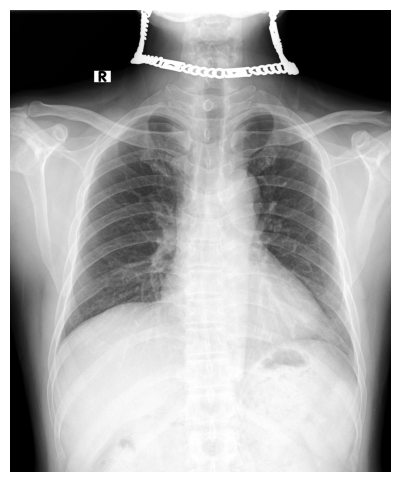


Disk space (KB) at /kaggle/working/images_all: free=20,442,508, total=20,466,256


In [3]:
# ONE-CELL CHECK: convert first 5 DICOMs -> RGB JPGs, report status, show one image
import pathlib, glob, os, pydicom, numpy as np, cv2, matplotlib.pyplot as plt, traceback

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
DST = "/kaggle/working/images_all"
os.makedirs(DST, exist_ok=True)

# find DICOMs (both .dcm and .dicom)
files = sorted(list(pathlib.Path(SRC).glob("*.dcm")) + list(pathlib.Path(SRC).glob("*.dicom")))
print("Found DICOM files in SRC:", len(files))
if len(files) == 0:
    print(" -> No DICOMs found at", SRC)
else:
    worked = 0
    for i, p in enumerate(files[:5]):
        try:
            print(f"\nConverting ({i+1}) {p.name} ...")
            ds = pydicom.dcmread(str(p), force=True)
            arr = ds.pixel_array.astype("float32")
            # handle photometric interpretation
            if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
                arr = arr.max() - arr
            # clip and normalize to uint8
            p1, p99 = np.percentile(arr, (1,99))
            arr = np.clip(arr, p1, p99)
            arr = arr - arr.min()
            if arr.max() > 0:
                arr_u8 = (arr / arr.max() * 255.0).astype("uint8")
            else:
                arr_u8 = arr.astype("uint8")
            # convert to RGB (3 channels)
            img_rgb = np.stack([arr_u8, arr_u8, arr_u8], axis=-1)
            out_name = os.path.splitext(p.name)[0] + ".jpg"
            out_path = os.path.join(DST, out_name)
            # write using cv2 (BGR expected)
            ok = cv2.imwrite(out_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
            size = os.path.getsize(out_path) if os.path.exists(out_path) else 0
            print(" write ok:", ok, " saved:", out_path, " size:", size)
            if ok and size>0:
                worked += 1
        except Exception as e:
            print(" FAILED converting", p.name)
            traceback.print_exc()

    print(f"\nConverted {worked}/{min(5,len(files))} files successfully.\n")
    # list files in DST
    dst_files = sorted(glob.glob(os.path.join(DST, "*.jpg")))
    print("Files currently in", DST, "->", len(dst_files))
    for f in dst_files[:20]:
        print("  ", os.path.basename(f), "-", os.path.getsize(f), "bytes")

    # show one of them if exists
    if dst_files:
        sample = dst_files[0]
        print("\nShowing preview of:", sample)
        img = cv2.imread(sample)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.show()
    else:
        print("\nNo JPGs found after writing attempts.")
    
    # show available disk space (KB)
    stat = os.statvfs(DST)
    free_kb = (stat.f_bavail * stat.f_frsize) // 1024
    total_kb = (stat.f_blocks * stat.f_frsize) // 1024
    print(f"\nDisk space (KB) at {DST}: free={free_kb:,}, total={total_kb:,}")


Total images: 5
Showing: 0007d316f756b3fa0baea2ff514ce945.jpg


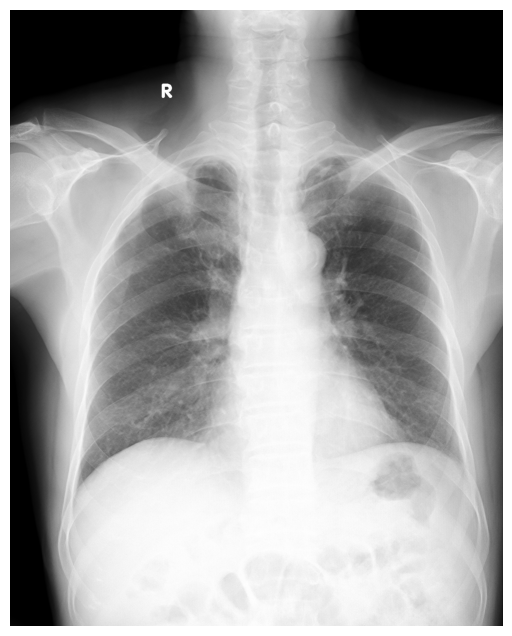

In [7]:
# A: Show a single random image
import glob, random, cv2, matplotlib.pyplot as plt, os
imgs = sorted(glob.glob("/kaggle/working/images_all/*.jpg"))
print("Total images:", len(imgs))
if not imgs:
    raise SystemExit("No images found in /kaggle/working/images_all")
path = random.choice(imgs)
print("Showing:", os.path.basename(path))
img = cv2.imread(path)[:, :, ::-1]   # BGR->RGB
plt.figure(figsize=(8,8)); plt.imshow(img); plt.axis("off"); plt.show()


Path: /kaggle/working/images_all/000434271f63a053c4128a0ba6352c7f.jpg  Shape: (2836, 2336, 3)


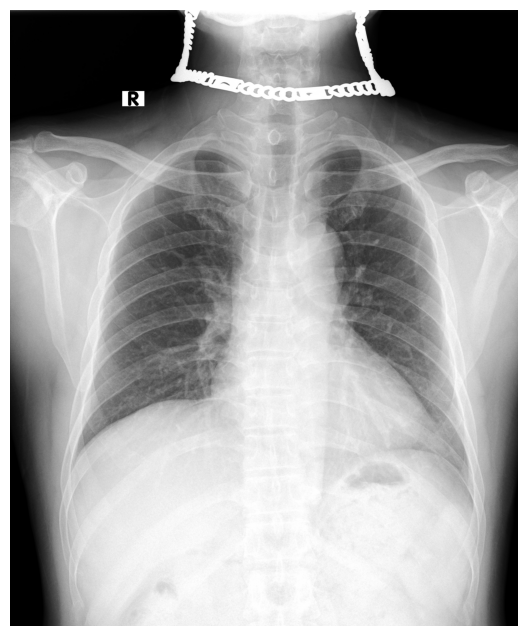

In [9]:
# B: View image by image_id (exact filename without extension)
import os, cv2, matplotlib.pyplot as plt
image_id = "000434271f63a053c4128a0ba6352c7f"   # <-- replace with any id
path = f"/kaggle/working/images_all/{image_id}.jpg"
if not os.path.exists(path):
    raise SystemExit(f"File not found: {path}")
img = cv2.imread(path)[:,:,::-1]
print("Path:", path, " Shape:", img.shape)
plt.figure(figsize=(8,8)); plt.imshow(img); plt.axis("off"); plt.show()


In [2]:
# Cell 1: show columns & a few rows of train.csv to detect bbox column names
import pandas as pd, os
csv_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"
print("train.csv exists:", os.path.exists(csv_path))
df = pd.read_csv(csv_path)
print("Columns:", list(df.columns))
print("\nFirst 5 rows:")
display(df.head())
print("\nDtypes:")
print(df.dtypes)


train.csv exists: True
Columns: ['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']

First 5 rows:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN



Dtypes:
image_id       object
class_name     object
class_id        int64
rad_id         object
x_min         float64
y_min         float64
x_max         float64
y_max         float64
dtype: object


In [1]:
# Cell 1: regenerate YOLO labels using x_min, y_min, x_max, y_max
import pandas as pd, os, pathlib
from PIL import Image

CSV_PATH = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"
IMG_DIR = "/kaggle/working/images_all"   # converted JPGs you created
OUT_DIR = "/kaggle/working/labels_all"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
print("Total CSV rows:", len(df))

# compute width/height from x_max/x_min
df["bbox_w"] = df["x_max"] - df["x_min"]
df["bbox_h"] = df["y_max"] - df["y_min"]

# drop rows with NaN boxes (No finding etc.)
df_boxes = df.dropna(subset=["x_min","y_min","x_max","y_max"]).copy()
print("Rows with boxes:", len(df_boxes))

# classes
class_names = sorted(df["class_name"].unique())
cls2id = {c:i for i,c in enumerate(class_names)}
print("Class mapping sample:", list(cls2id.items())[:6])

# iterate grouped by image_id but only for images that exist in converted folder
converted_imgs = {p.stem for p in pathlib.Path(IMG_DIR).glob("*.jpg")}
written = 0
for img_id, g in df_boxes.groupby("image_id"):
    if img_id not in converted_imgs:
        continue
    img_path = os.path.join(IMG_DIR, img_id + ".jpg")
    if not os.path.exists(img_path):
        continue
    W, H = Image.open(img_path).size
    lines = []
    for _, row in g.iterrows():
        x_min = float(row["x_min"]); y_min = float(row["y_min"])
        bw = float(row["bbox_w"]); bh = float(row["bbox_h"])
        # if invalid bbox size skip
        if bw <= 0 or bh <= 0:
            continue
        # normalize according to converted image size
        x_c = (x_min + bw/2.0) / W
        y_c = (y_min + bh/2.0) / H
        w_n = bw / W
        h_n = bh / H
        cls_id = cls2id[row["class_name"]]
        lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")
    if lines:
        with open(os.path.join(OUT_DIR, img_id + ".txt"), "w") as f:
            f.write("\n".join(lines))
        written += 1

print("Wrote YOLO label files:", written, "to", OUT_DIR)
# save classes file
with open("/kaggle/working/classes.txt", "w") as f:
    f.write("\n".join(class_names))
print("Saved class list to /kaggle/working/classes.txt")


Total CSV rows: 67914
Rows with boxes: 36096
Class mapping sample: [('Aortic enlargement', 0), ('Atelectasis', 1), ('Calcification', 2), ('Cardiomegaly', 3), ('Consolidation', 4), ('ILD', 5)]
Wrote YOLO label files: 0 to /kaggle/working/labels_all
Saved class list to /kaggle/working/classes.txt


Total DICOMs available: 15000
Converting first 100 files to: /kaggle/working/images_all


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Converted 100/100 files.
Sample converted files (up to 10):
  /kaggle/working/images_all/000434271f63a053c4128a0ba6352c7f.jpg - 1517275 bytes
  /kaggle/working/images_all/00053190460d56c53cc3e57321387478.jpg - 629529 bytes
  /kaggle/working/images_all/0005e8e3701dfb1dd93d53e2ff537b6e.jpg - 1016110 bytes
  /kaggle/working/images_all/0006e0a85696f6bb578e84fafa9a5607.jpg - 2479534 bytes
  /kaggle/working/images_all/0007d316f756b3fa0baea2ff514ce945.jpg - 1807466 bytes
  /kaggle/working/images_all/000ae00eb3942d27e0b97903dd563a6e.jpg - 1519583 bytes
  /kaggle/working/images_all/000d68e42b71d3eac10ccc077aba07c1.jpg - 2059281 bytes
  /kaggle/working/images_all/00150343289f317a0ad5629d5b7d9ef9.jpg - 2348487 bytes
  /kaggle/working/images_all/00176f7e1b1cb835123f95960b9a9efd.jpg - 2502140 bytes
  /kaggle/working/images_all/001d127bad87592efe45a5c7678f8b8d.jpg - 1016467 bytes


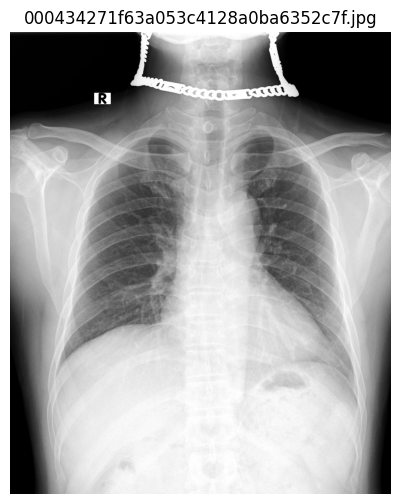

In [3]:
# RUN THIS CELL: convert first 100 DICOMs -> RGB JPGs, save to /kaggle/working/images_all and verify
import pathlib, os, pydicom, numpy as np, cv2, tqdm, glob, matplotlib.pyplot as plt

SRC = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
DST = "/kaggle/working/images_all"
os.makedirs(DST, exist_ok=True)

# Limit for quick test; set N = total if you want to convert everything later
N = 100

files = sorted(list(pathlib.Path(SRC).glob("*.dcm")) + list(pathlib.Path(SRC).glob("*.dicom")))
print("Total DICOMs available:", len(files))
files = files[:N]
print("Converting first", len(files), "files to:", DST)

converted = []
for p in tqdm.tqdm(files):
    try:
        ds = pydicom.dcmread(str(p), force=True)
        arr = ds.pixel_array.astype("float32")
        if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
            arr = arr.max() - arr
        p1, p99 = np.percentile(arr, (1,99))
        arr = np.clip(arr, p1, p99)
        arr = arr - arr.min()
        if arr.max() > 0:
            arr_u8 = (arr / arr.max() * 255.0).astype("uint8")
        else:
            arr_u8 = arr.astype("uint8")
        img_rgb = np.stack([arr_u8, arr_u8, arr_u8], axis=-1)
        out_name = os.path.splitext(os.path.basename(str(p)))[0] + ".jpg"
        out_path = os.path.join(DST, out_name)
        ok = cv2.imwrite(out_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        if ok and os.path.exists(out_path) and os.path.getsize(out_path) > 0:
            converted.append(out_path)
    except Exception as e:
        print("FAILED:", p.name, "->", e)

print(f"Converted {len(converted)}/{len(files)} files.")
print("Sample converted files (up to 10):")
for f in converted[:10]:
    print(" ", f, "-", os.path.getsize(f), "bytes")

# quick preview of first converted image if exists
if converted:
    sample = converted[0]
    img = cv2.imread(sample)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.title(os.path.basename(sample)); plt.show()
else:
    print("No files were converted. Check any errors printed above.")


No label file for 0191b567f08216ca642e04ef05537169 - showing image without boxes


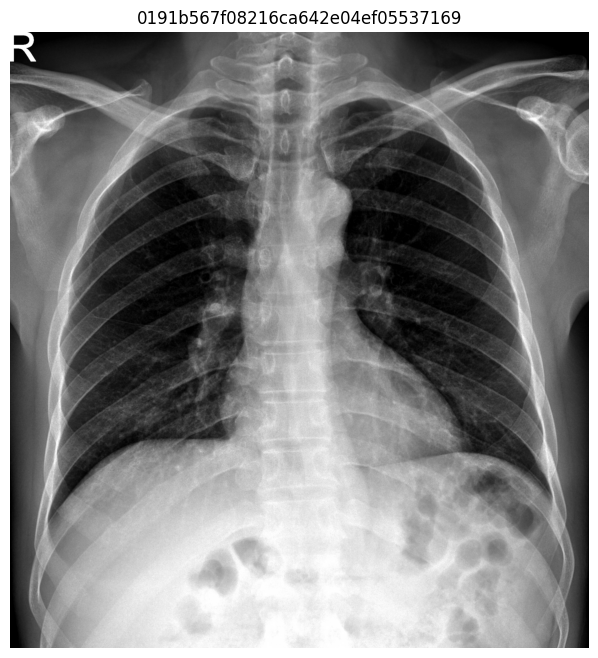

In [5]:
# Cell 3: display a sample image from train with YOLO boxes overlayed
import random, glob, cv2, matplotlib.pyplot as plt, os

train_imgs = glob.glob("/kaggle/working/images/train/*.jpg")
if not train_imgs:
    raise SystemExit("No images in /kaggle/working/images/train — run Cell 2 first")
sample = random.choice(train_imgs)
img = cv2.imread(sample)
h,w = img.shape[:2]
img_id = os.path.splitext(os.path.basename(sample))[0]
lbl = f"/kaggle/working/labels/train/{img_id}.txt"

if os.path.exists(lbl):
    with open(lbl) as f:
        for line in f:
            cls, xc, yc, wn, hn = map(float, line.split())
            x1 = int((xc - wn/2.0) * w); x2 = int((xc + wn/2.0) * w)
            y1 = int((yc - hn/2.0) * h); y2 = int((yc + hn/2.0) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            # class name
            classes_file = "/kaggle/working/classes.txt"
            if os.path.exists(classes_file):
                cnames = [l.strip() for l in open(classes_file) if l.strip()]
                label_text = cnames[int(cls)] if int(cls) < len(cnames) else str(int(cls))
            else:
                label_text = str(int(cls))
            cv2.putText(img, label_text, (x1, max(12,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
else:
    print("No label file for", img_id, "- showing image without boxes")

plt.figure(figsize=(8,8)); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(img_id); plt.show()


In [8]:
# (1) regenerate YOLO labels using x_min/x_max (run this first)
import pandas as pd, os, pathlib
from PIL import Image

CSV_PATH = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"
IMG_DIR = "/kaggle/working/images_all"   # converted JPGs
OUT_DIR = "/kaggle/working/labels_all"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
df["bbox_w"] = df["x_max"] - df["x_min"]
df["bbox_h"] = df["y_max"] - df["y_min"]
df_boxes = df.dropna(subset=["x_min","y_min","x_max","y_max"]).copy()

class_names = sorted(df["class_name"].unique())
cls2id = {c:i for i,c in enumerate(class_names)}

converted_imgs = {p.stem for p in pathlib.Path(IMG_DIR).glob("*.jpg")}
written = 0
for img_id, g in df_boxes.groupby("image_id"):
    if img_id not in converted_imgs:
        continue
    img_path = os.path.join(IMG_DIR, img_id + ".jpg")
    if not os.path.exists(img_path):
        continue
    W, H = Image.open(img_path).size
    lines = []
    for _, row in g.iterrows():
        x_min = float(row["x_min"]); y_min = float(row["y_min"])
        bw = float(row["bbox_w"]); bh = float(row["bbox_h"])
        if bw <= 0 or bh <= 0:
            continue
        x_c = (x_min + bw/2.0) / W
        y_c = (y_min + bh/2.0) / H
        w_n = bw / W
        h_n = bh / H
        cls_id = cls2id[row["class_name"]]
        lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")
    if lines:
        with open(os.path.join(OUT_DIR, img_id + ".txt"), "w") as f:
            f.write("\n".join(lines))
        written += 1

print("YOLO label files written (non-empty):", written, "to", OUT_DIR)
# save classes
with open("/kaggle/working/classes.txt","w") as f:
    f.write("\n".join(class_names))
print("Saved classes to /kaggle/working/classes.txt")


YOLO label files written (non-empty): 31 to /kaggle/working/labels_all
Saved classes to /kaggle/working/classes.txt


In [9]:
# (2) ensure every converted image has a .txt (create empty files where needed)
import pathlib, os

IMG_ALL = pathlib.Path("/kaggle/working/images_all")
LAB_ALL = pathlib.Path("/kaggle/working/labels_all")
LAB_ALL.mkdir(parents=True, exist_ok=True)

created = 0
for p in IMG_ALL.glob("*.jpg"):
    txt = LAB_ALL / (p.stem + ".txt")
    if not txt.exists():
        txt.write_text("")   # create empty file for negative sample
        created += 1

print("Empty label files created for no-box images:", created)
print("Total label files now:", len(list(LAB_ALL.glob("*.txt"))))


Empty label files created for no-box images: 69
Total label files now: 100


train -> images:   70  labels:   70
val   -> images:   15  labels:   15
test  -> images:   15  labels:   15
Sample: 008b3176a7248a0a189b5731ac8d2e95 | boxes drawn: 12


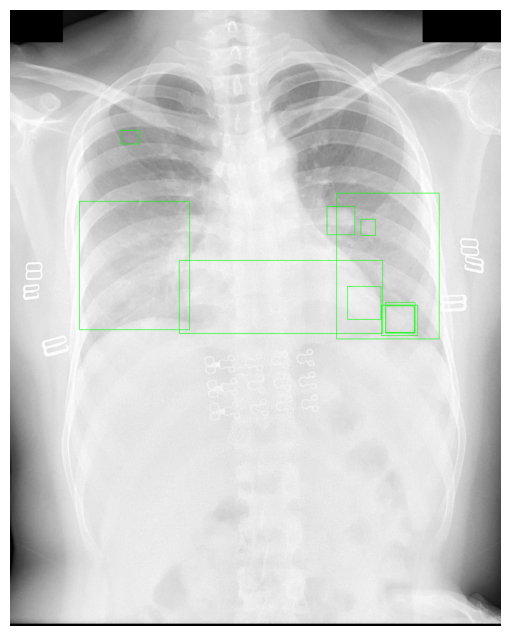

In [10]:
# (3) copy labels_all -> labels/{train,val,test} to match images in each split and show a sample
import shutil, pathlib, glob, random, cv2, matplotlib.pyplot as plt, os

IMG_SPLIT = pathlib.Path("/kaggle/working/images")
LAB_SPLIT = pathlib.Path("/kaggle/working/labels")
LAB_ALL = pathlib.Path("/kaggle/working/labels_all")

# copy labels for each image in split
for split in ["train","val","test"]:
    labdir = LAB_SPLIT.joinpath(split)
    labdir.mkdir(parents=True, exist_ok=True)
    for imgp in IMG_SPLIT.joinpath(split).glob("*.jpg"):
        src = LAB_ALL.joinpath(imgp.stem + ".txt")
        dst = labdir.joinpath(imgp.stem + ".txt")
        if src.exists():
            shutil.copy(src, dst)
        else:
            dst.write_text("")

# print counts
for split in ["train","val","test"]:
    imc = len(list(IMG_SPLIT.joinpath(split).glob("*.jpg")))
    lbc = len(list(LAB_SPLIT.joinpath(split).glob("*.txt")))
    print(f"{split:5s} -> images: {imc:4d}  labels: {lbc:4d}")

# show a random train sample with boxes if present
train_imgs = glob.glob("/kaggle/working/images/train/*.jpg")
if not train_imgs:
    print("No train images found.")
else:
    sample = random.choice(train_imgs)
    img = cv2.imread(sample)
    h,w = img.shape[:2]
    img_id = os.path.splitext(os.path.basename(sample))[0]
    lbl = f"/kaggle/working/labels/train/{img_id}.txt"
    boxes = 0
    if os.path.exists(lbl):
        with open(lbl) as f:
            for line in f:
                if not line.strip(): continue
                cls, xc, yc, wn, hn = map(float, line.split())
                x1 = int((xc - wn/2.0) * w); x2 = int((xc + wn/2.0) * w)
                y1 = int((yc - hn/2.0) * h); y2 = int((yc + hn/2.0) * h)
                cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
                boxes += 1
    print("Sample:", img_id, "| boxes drawn:", boxes)
    plt.figure(figsize=(8,8)); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()


In [2]:
# FULL PIPELINE: Convert all DICOMs -> RGB JPGs, create YOLO labels, create empty labels for negatives,
# split into train/val/test (70/15/15), and write dataset.yaml.
# Resume-friendly: will skip images already converted and labels already created.

import os, pathlib, pydicom, numpy as np, cv2, shutil, random, yaml, math, sys
from PIL import Image
import tqdm, glob, time
import pandas as pd

# ---------- CONFIG ----------
SRC_DICOM_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
OUT_IMG_DIR   = "/kaggle/working/images_all"    # converted jpgs
OUT_LABEL_DIR = "/kaggle/working/labels_all"    # YOLO .txt labels (normalized)
SPLIT_IMG_DIR = "/kaggle/working/images"        # images/train,val,test
SPLIT_LAB_DIR = "/kaggle/working/labels"        # labels/train,val,test
DATASET_YAML  = "/kaggle/working/dataset.yaml"
CSV_PATH      = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"

CONVERT_ALL   = True        # Set False to convert just first MAX_TO_CONVERT files for testing
MAX_TO_CONVERT = 3000       # only used when CONVERT_ALL=False
MAX_EDGE = 1024             # resize long edge to this (keeps disk reasonable)

# Safety: make dirs
os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_LABEL_DIR, exist_ok=True)
os.makedirs(SPLIT_IMG_DIR, exist_ok=True)
os.makedirs(SPLIT_LAB_DIR, exist_ok=True)

# ---------- Helper functions ----------
def read_and_normalize_dicom(path):
    ds = pydicom.dcmread(path, force=True)
    arr = ds.pixel_array.astype("float32")
    # PhotometricInterpretation handling
    if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
        arr = arr.max() - arr
    # Rescale with slope/intercept if present
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    arr = arr * slope + intercept
    # clip percentiles to improve contrast
    p1,p99 = np.percentile(arr, (1,99))
    arr = np.clip(arr, p1, p99)
    arr = arr - arr.min()
    if arr.max() > 0:
        arr_u8 = (arr / arr.max() * 255.0).astype("uint8")
    else:
        arr_u8 = arr.astype("uint8")
    return arr_u8

def save_rgb_jpg(u8_img, out_path, max_edge=MAX_EDGE):
    # convert grayscale uint8 -> 3-channel RGB and resize if needed
    if u8_img.ndim == 2:
        img_rgb = np.stack([u8_img, u8_img, u8_img], axis=-1)
    elif u8_img.ndim == 3 and u8_img.shape[2] == 1:
        img_rgb = np.concatenate([u8_img]*3, axis=2)
    else:
        img_rgb = u8_img
    h,w = img_rgb.shape[:2]
    if max(h,w) > max_edge:
        scale = max_edge / max(h,w)
        neww = int(w*scale); newh = int(h*scale)
        img_rgb = cv2.resize(img_rgb, (neww,newh), interpolation=cv2.INTER_AREA)
    # cv2 expects BGR
    ok = cv2.imwrite(out_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    return ok

# ---------- Convert DICOM -> JPG (resume-friendly) ----------
dcm_files = sorted(list(pathlib.Path(SRC_DICOM_DIR).glob("*.dcm")) + list(pathlib.Path(SRC_DICOM_DIR).glob("*.dicom")))
total_dcms = len(dcm_files)
print("Found DICOMs:", total_dcms)

if total_dcms == 0:
    raise SystemExit("No DICOM files found at: " + SRC_DICOM_DIR)

to_process = dcm_files if CONVERT_ALL else dcm_files[:MAX_TO_CONVERT]
print("Converting count:", len(to_process), "(CONVERT_ALL={})".format(CONVERT_ALL))

converted = 0
start = time.time()
for p in tqdm.tqdm(to_process):
    out_name = os.path.splitext(os.path.basename(str(p)))[0] + ".jpg"
    out_path = os.path.join(OUT_IMG_DIR, out_name)
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        # already converted
        continue
    try:
        u8 = read_and_normalize_dicom(str(p))
        ok = save_rgb_jpg(u8, out_path)
        if ok:
            converted += 1
        else:
            print("WARN: cv2.imwrite returned False for", out_path)
    except Exception as e:
        print("Error converting", p, ":", e)
print(f"Conversion done. Newly converted: {converted}. Time elapsed: {time.time()-start:.1f}s")
print("Total JPGs in", OUT_IMG_DIR, "=", len(list(pathlib.Path(OUT_IMG_DIR).glob('*.jpg'))))

# ---------- Build YOLO .txt labels normalized to converted image sizes ----------
print("Reading CSV and creating YOLO labels (normalized to converted image sizes)...")
df = pd.read_csv(CSV_PATH)
# columns expected: image_id, class_name, class_id, rad_id, x_min,y_min,x_max,y_max
required_cols = ["image_id","class_name","x_min","y_min","x_max","y_max"]
for c in required_cols:
    if c not in df.columns:
        raise SystemExit(f"CSV missing required column: {c}")

df["bbox_w"] = df["x_max"] - df["x_min"]
df["bbox_h"] = df["y_max"] - df["y_min"]
df_boxes = df.dropna(subset=["x_min","y_min","x_max","y_max"]).copy()
class_names = sorted(df["class_name"].unique())
cls2id = {c:i for i,c in enumerate(class_names)}
print("Classes count:", len(class_names))

converted_set = {p.stem for p in pathlib.Path(OUT_IMG_DIR).glob("*.jpg")}
written = 0
for img_id, group in df_boxes.groupby("image_id"):
    if img_id not in converted_set:
        continue
    img_path = os.path.join(OUT_IMG_DIR, img_id + ".jpg")
    try:
        W,H = Image.open(img_path).size
    except Exception as e:
        # skip if image can't be opened
        continue
    lines = []
    for _, r in group.iterrows():
        x_min = float(r["x_min"]); y_min = float(r["y_min"])
        bw = float(r["bbox_w"]); bh = float(r["bbox_h"])
        if bw <= 0 or bh <= 0:
            continue
        x_c = (x_min + bw/2.0) / W
        y_c = (y_min + bh/2.0) / H
        w_n = bw / W
        h_n = bh / H
        cls_id = cls2id[r["class_name"]]
        # ensure normalized values in (0,1)
        if not (0 <= x_c <= 1 and 0 <= y_c <= 1 and 0 < w_n <= 1 and 0 < h_n <= 1):
            # clip to valid range or skip if completely invalid
            # we clip here to avoid training crashes but you may want to inspect such boxes later
            x_c = max(0.0, min(1.0, x_c))
            y_c = max(0.0, min(1.0, y_c))
            w_n = max(0.0, min(1.0, w_n))
            h_n = max(0.0, min(1.0, h_n))
        lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")
    if lines:
        with open(os.path.join(OUT_LABEL_DIR, img_id + ".txt"), "w") as fh:
            fh.write("\n".join(lines))
        written += 1

print("Non-empty YOLO label files written:", written, "to", OUT_LABEL_DIR)

# ---------- Create empty .txt files for images with no boxes (negatives) ----------
print("Ensuring every converted image has a .txt (create empties for negatives)...")
created_empty = 0
for p in pathlib.Path(OUT_IMG_DIR).glob("*.jpg"):
    txt = pathlib.Path(OUT_LABEL_DIR) / (p.stem + ".txt")
    if not txt.exists():
        txt.write_text("")
        created_empty += 1
print("Empty label files created:", created_empty, "Total labels now:", len(list(pathlib.Path(OUT_LABEL_DIR).glob('*.txt'))))

# ---------- Create train/val/test split (70/15/15) and copy images + labels ----------
print("Creating train/val/test splits (70/15/15) and copying files...")

all_imgs = sorted(list(pathlib.Path(OUT_IMG_DIR).glob("*.jpg")))
all_ids = [p.stem for p in all_imgs]
random.seed(42)
random.shuffle(all_ids)
n = len(all_ids)
ntrain = int(0.7 * n)
nval = int(0.15 * n)
train_ids = all_ids[:ntrain]
val_ids = all_ids[ntrain:ntrain+nval]
test_ids = all_ids[ntrain+nval:]

# create folders
for split, ids in [("train", train_ids), ("val", val_ids), ("test", test_ids)]:
    imdir = pathlib.Path(SPLIT_IMG_DIR) / split
    lbdir = pathlib.Path(SPLIT_LAB_DIR) / split
    imdir.mkdir(parents=True, exist_ok=True)
    lbdir.mkdir(parents=True, exist_ok=True)
    for img_id in ids:
        src_img = pathlib.Path(OUT_IMG_DIR) / (img_id + ".jpg")
        dst_img = imdir / (img_id + ".jpg")
        if not dst_img.exists():
            shutil.copy(src_img, dst_img)
        src_lbl = pathlib.Path(OUT_LABEL_DIR) / (img_id + ".txt")
        dst_lbl = lbdir / (img_id + ".txt")
        if not dst_lbl.exists() and src_lbl.exists():
            shutil.copy(src_lbl, dst_lbl)

print("Splits created. Counts:")
print(" images/train:", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("train").glob("*.jpg"))))
print(" labels/train:", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("train").glob("*.txt"))))
print(" images/val:  ", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("val").glob("*.jpg"))))
print(" labels/val:  ", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("val").glob("*.txt"))))
print(" images/test: ", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("test").glob("*.jpg"))))
print(" labels/test: ", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("test").glob("*.txt"))))

# ---------- Write dataset.yaml for ultralytics (YOLOv8) ----------
dataset_yaml = {
    "path": "/kaggle/working",
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": {i: n for i, n in enumerate(class_names)}
}
with open(DATASET_YAML, "w") as fh:
    yaml.dump(dataset_yaml, fh)
print("Wrote dataset.yaml ->", DATASET_YAML)
print("Pipeline finished. You can now train YOLO using dataset.yaml and runs will use images/ and labels/ splits.")


Found DICOMs: 15000
Converting count: 15000 (CONVERT_ALL=True)


100%|██████████| 15000/15000 [4:50:30<00:00,  1.16s/it]  


Conversion done. Newly converted: 15000. Time elapsed: 17430.2s
Total JPGs in /kaggle/working/images_all = 15000
Reading CSV and creating YOLO labels (normalized to converted image sizes)...
Classes count: 15
Non-empty YOLO label files written: 4394 to /kaggle/working/labels_all
Ensuring every converted image has a .txt (create empties for negatives)...
Empty label files created: 10606 Total labels now: 15000
Creating train/val/test splits (70/15/15) and copying files...
Splits created. Counts:
 images/train: 10500
 labels/train: 10500
 images/val:   2250
 labels/val:   2250
 images/test:  2250
 labels/test:  2250
Wrote dataset.yaml -> /kaggle/working/dataset.yaml
Pipeline finished. You can now train YOLO using dataset.yaml and runs will use images/ and labels/ splits.


In [1]:
# Cell A: build cls_labels.csv (multi-label image-level)
import pandas as pd, pathlib, os
csv = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"
imgs_dir = "/kaggle/working/images_all"   # converted images
out_csv = "/kaggle/working/cls_labels.csv"

df = pd.read_csv(csv)
# classes in dataset
classes = sorted(df["class_name"].unique())
print("Classes:", classes)
# create per-image aggregation (1 if any bbox of that class present)
grouped = df.groupby("image_id")["class_name"].apply(list).reset_index()
rows = []
for _, r in grouped.iterrows():
    img_id = r["image_id"]
    labels_present = set(r["class_name"])
    row = {"image_id": img_id, "image_path": os.path.join(imgs_dir, f"{img_id}.jpg")}
    for cl in classes:
        row[cl] = 1 if cl in labels_present else 0
    rows.append(row)
cls_df = pd.DataFrame(rows)
# Keep only images that exist in converted image folder
cls_df = cls_df[cls_df["image_path"].map(lambda p: os.path.exists(p))]
cls_df.to_csv(out_csv, index=False)
print("Wrote", out_csv, "with", len(cls_df), "rows")
display(cls_df.head())


Classes: ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
Wrote /kaggle/working/cls_labels.csv with 0 rows


,image_id,image_path,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,No finding,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis


In [1]:
# Resume-friendly conversion + label creation (subset default)
# Paste this whole cell and run once. Adjust CONVERT_ALL / MAX_TO_CONVERT below.
import os, pathlib, pydicom, numpy as np, cv2, shutil, random, yaml, time
from PIL import Image
import pandas as pd
import tqdm

# ---------- CONFIG ----------
SRC_DICOM_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
OUT_IMG_DIR   = "/kaggle/working/images_all"    # converted jpgs (output)
OUT_LABEL_DIR = "/kaggle/working/labels_all"    # YOLO .txt labels (normalized)
SPLIT_IMG_DIR = "/kaggle/working/images"        # images/train,val,test
SPLIT_LAB_DIR = "/kaggle/working/labels"        # labels/train,val,test
DATASET_YAML  = "/kaggle/working/dataset.yaml"
CSV_PATH      = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"

# Toggle for testing vs full run
CONVERT_ALL   = False       # False -> convert only MAX_TO_CONVERT files (fast test). True -> convert all 15000 (long)
MAX_TO_CONVERT = 3000       # used only when CONVERT_ALL=False. Set to 15000 for full conversion.
MAX_EDGE = 1024             # resize long edge to this (reduces disk)

# ---------- ensure dirs ----------
os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_LABEL_DIR, exist_ok=True)
os.makedirs(SPLIT_IMG_DIR, exist_ok=True)
os.makedirs(SPLIT_LAB_DIR, exist_ok=True)

# ---------- helper ----------
def read_and_norm_dicom(path):
    ds = pydicom.dcmread(path, force=True)
    arr = ds.pixel_array.astype("float32")
    if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
        arr = arr.max() - arr
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    arr = arr * slope + intercept
    p1,p99 = np.percentile(arr, (1,99))
    arr = np.clip(arr, p1, p99)
    arr = arr - arr.min()
    if arr.max() > 0:
        u8 = (arr / arr.max() * 255.0).astype("uint8")
    else:
        u8 = arr.astype("uint8")
    return u8

def save_rgb_jpg(u8_img, out_path, max_edge=MAX_EDGE):
    if u8_img.ndim == 2:
        img_rgb = np.stack([u8_img, u8_img, u8_img], axis=-1)
    else:
        img_rgb = u8_img
    h,w = img_rgb.shape[:2]
    if max(h,w) > max_edge:
        scale = max_edge / max(h,w)
        img_rgb = cv2.resize(img_rgb, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    # write with cv2 (BGR)
    ok = cv2.imwrite(out_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    return ok

# ---------- discover dicoms ----------
dicom_files = sorted(list(pathlib.Path(SRC_DICOM_DIR).glob("*.dcm")) + list(pathlib.Path(SRC_DICOM_DIR).glob("*.dicom")))
if len(dicom_files) == 0:
    raise SystemExit(f"No DICOM files found in {SRC_DICOM_DIR}")
print("Found DICOMs:", len(dicom_files))

to_process = dicom_files if CONVERT_ALL else dicom_files[:MAX_TO_CONVERT]
print("Converting count:", len(to_process), "(CONVERT_ALL={})".format(CONVERT_ALL))

# Convert (resume-friendly: skip existing files)
converted_new = 0
t0 = time.time()
for p in tqdm.tqdm(to_process):
    out_name = os.path.splitext(os.path.basename(str(p)))[0] + ".jpg"
    out_path = os.path.join(OUT_IMG_DIR, out_name)
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        continue
    try:
        u8 = read_and_norm_dicom(str(p))
        ok = save_rgb_jpg(u8, out_path)
        if ok:
            converted_new += 1
        else:
            print("WARN: failed to write", out_path)
    except Exception as e:
        print("Error converting", p, ":", e)
print(f"Conversion done. Newly converted: {converted_new}. Time elapsed: {time.time()-t0:.1f}s")
print("Total JPGs in", OUT_IMG_DIR, "=", len(list(pathlib.Path(OUT_IMG_DIR).glob('*.jpg'))))

# ---------- Build YOLO .txt labels (normalized) ----------
print("Creating YOLO labels normalized to converted image sizes...")
df = pd.read_csv(CSV_PATH)
df["bbox_w"] = df["x_max"] - df["x_min"]
df["bbox_h"] = df["y_max"] - df["y_min"]
df_boxes = df.dropna(subset=["x_min","y_min","x_max","y_max"]).copy()
class_names = sorted(df["class_name"].unique())
cls2id = {c:i for i,c in enumerate(class_names)}
print("Detected classes:", len(class_names))

converted_set = {p.stem for p in pathlib.Path(OUT_IMG_DIR).glob("*.jpg")}
written = 0
for img_id, group in df_boxes.groupby("image_id"):
    if img_id not in converted_set:
        continue
    img_path = os.path.join(OUT_IMG_DIR, img_id + ".jpg")
    try:
        W,H = Image.open(img_path).size
    except Exception:
        continue
    lines=[]
    for _, r in group.iterrows():
        x_min = float(r["x_min"]); y_min = float(r["y_min"])
        bw = float(r["bbox_w"]); bh = float(r["bbox_h"])
        if bw <= 0 or bh <= 0:
            continue
        x_c = (x_min + bw/2.0) / W
        y_c = (y_min + bh/2.0) / H
        w_n = bw / W
        h_n = bh / H
        cls_id = cls2id[r["class_name"]]
        # clip to [0,1]
        x_c = max(0.0, min(1.0, x_c)); y_c = max(0.0, min(1.0, y_c))
        w_n = max(0.0, min(1.0, w_n)); h_n = max(0.0, min(1.0, h_n))
        lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")
    if lines:
        with open(os.path.join(OUT_LABEL_DIR, img_id + ".txt"), "w") as fh:
            fh.write("\n".join(lines))
        written += 1

print("Non-empty YOLO label files written:", written, "to", OUT_LABEL_DIR)

# ---------- Create empty .txt for negatives ----------
created_empty = 0
for p in pathlib.Path(OUT_IMG_DIR).glob("*.jpg"):
    txt = pathlib.Path(OUT_LABEL_DIR) / (p.stem + ".txt")
    if not txt.exists():
        txt.write_text("")
        created_empty += 1
print("Empty label files created:", created_empty, "Total labels now:", len(list(pathlib.Path(OUT_LABEL_DIR).glob('*.txt'))))

# ---------- Create train/val/test split (70/15/15) ----------
print("Creating train/val/test splits (70/15/15)...")
all_imgs = sorted(list(pathlib.Path(OUT_IMG_DIR).glob("*.jpg")))
all_ids = [p.stem for p in all_imgs]
random.seed(42)
random.shuffle(all_ids)
n = len(all_ids)
ntrain = int(0.7 * n)
nval = int(0.15 * n)
train_ids = all_ids[:ntrain]; val_ids = all_ids[ntrain:ntrain+nval]; test_ids = all_ids[ntrain+nval:]

for split, ids in [("train", train_ids), ("val", val_ids), ("test", test_ids)]:
    imdir = pathlib.Path(SPLIT_IMG_DIR) / split; imdir.mkdir(parents=True, exist_ok=True)
    lbdir = pathlib.Path(SPLIT_LAB_DIR) / split; lbdir.mkdir(parents=True, exist_ok=True)
    for img_id in ids:
        src_img = pathlib.Path(OUT_IMG_DIR) / (img_id + ".jpg")
        dst_img = imdir / (img_id + ".jpg")
        if src_img.exists() and not dst_img.exists():
            shutil.copy(src_img, dst_img)
        src_lbl = pathlib.Path(OUT_LABEL_DIR) / (img_id + ".txt")
        dst_lbl = lbdir / (img_id + ".txt")
        if src_lbl.exists() and not dst_lbl.exists():
            shutil.copy(src_lbl, dst_lbl)

print("Splits created. Example counts:")
print(" images/train:", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("train").glob("*.jpg"))))
print(" labels/train:", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("train").glob("*.txt"))))
print(" images/val:  ", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("val").glob("*.jpg"))))
print(" labels/val:  ", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("val").glob("*.txt"))))
print(" images/test: ", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("test").glob("*.jpg"))))
print(" labels/test: ", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("test").glob("*.txt"))))

# ---------- Write dataset.yaml ----------
dataset_yaml = {
    "path": "/kaggle/working",
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": {i: n for i, n in enumerate(class_names)}
}
with open(DATASET_YAML, "w") as fh:
    yaml.dump(dataset_yaml, fh)
print("Wrote dataset.yaml ->", DATASET_YAML)
print("ALL DONE for this run. If you ran with CONVERT_ALL=False, set CONVERT_ALL=True to convert the entire dataset.")


Found DICOMs: 15000
Converting count: 3000 (CONVERT_ALL=False)


100%|██████████| 3000/3000 [1:08:44<00:00,  1.37s/it]


Conversion done. Newly converted: 3000. Time elapsed: 4124.9s
Total JPGs in /kaggle/working/images_all = 3000
Creating YOLO labels normalized to converted image sizes...
Detected classes: 15
Non-empty YOLO label files written: 898 to /kaggle/working/labels_all
Empty label files created: 2102 Total labels now: 3000
Creating train/val/test splits (70/15/15)...
Splits created. Example counts:
 images/train: 2100
 labels/train: 2100
 images/val:   450
 labels/val:   450
 images/test:  450
 labels/test:  450
Wrote dataset.yaml -> /kaggle/working/dataset.yaml
ALL DONE for this run. If you ran with CONVERT_ALL=False, set CONVERT_ALL=True to convert the entire dataset.


In [2]:
# Build cls_labels.csv from train.csv using only converted images
import pandas as pd, glob, os, pathlib

CSV_IN = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"
IMG_DIR = "/kaggle/working/images_all"
OUT_CSV = "/kaggle/working/cls_labels.csv"

df = pd.read_csv(CSV_IN)
classes = sorted(df["class_name"].unique())
print("Classes:", classes)

# get available converted image ids
files = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
print("Converted images found:", len(files))
file_map = {os.path.splitext(os.path.basename(f))[0].lower(): f for f in files}
filenames = [os.path.basename(f).lower() for f in files]

rows = []
image_ids = df["image_id"].unique()
for img_id in image_ids:
    img_id_lower = str(img_id).lower()
    matched_path = None
    if img_id_lower in file_map:
        matched_path = file_map[img_id_lower]
    else:
        # prefix match
        for fn, full in file_map.items():
            if fn.startswith(img_id_lower):
                matched_path = full; break
    if not matched_path:
        for fn, full in file_map.items():
            if img_id_lower in fn:
                matched_path = full; break
    if matched_path:
        cls_present = set(df[df["image_id"]==img_id]["class_name"].tolist())
        row = {"image_id": img_id, "image_path": matched_path}
        for cl in classes:
            row[cl] = 1 if cl in cls_present else 0
        rows.append(row)

out_df = pd.DataFrame(rows)
out_df.to_csv(OUT_CSV, index=False)
print("Wrote", OUT_CSV, "with", len(out_df), "rows (matched images). Sample:")
display(out_df.head())


Classes: ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
Converted images found: 3000
Wrote /kaggle/working/cls_labels.csv with 3000 rows (matched images). Sample:


,image_id,image_path,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,No finding,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,21a10246a5ec7af151081d0cd6d65dc9,/kaggle/working/images_all/21a10246a5ec7af1510...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,051132a778e61a86eb147c7c6f564dfe,/kaggle/working/images_all/051132a778e61a86eb1...,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,063319de25ce7edb9b1c6b8881290140,/kaggle/working/images_all/063319de25ce7edb9b1...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1c32170b4af4ce1a3030eb8167753b06,/kaggle/working/images_all/1c32170b4af4ce1a303...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0c7a38f293d5f5e4846aa4ca6db4daf1,/kaggle/working/images_all/0c7a38f293d5f5e4846...,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0


In [4]:


import os, pathlib, pydicom, numpy as np, cv2, shutil, random, yaml, time
from PIL import Image
import pandas as pd
import tqdm, glob

# ---------- CONFIG ----------
SRC_DICOM_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
OUT_IMG_DIR   = "/kaggle/working/images_all"    # converted jpgs
OUT_LABEL_DIR = "/kaggle/working/labels_all"    # YOLO .txt labels (normalized)
SPLIT_IMG_DIR = "/kaggle/working/images"        # images/train,val,test
SPLIT_LAB_DIR = "/kaggle/working/labels"        # labels/train,val,test
DATASET_YAML  = "/kaggle/working/dataset.yaml"
CSV_PATH      = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"

# Toggle for testing vs full run
CONVERT_ALL   = False       # False -> convert only MAX_TO_CONVERT files (fast test). True -> convert all 15000 (long)
MAX_TO_CONVERT = 3000       # used only when CONVERT_ALL=False. Set to 15000 for full conversion.
MAX_EDGE = 1024             # resize long edge to this (reduces disk)

# ---------- ensure dirs ----------
os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_LABEL_DIR, exist_ok=True)
os.makedirs(SPLIT_IMG_DIR, exist_ok=True)
os.makedirs(SPLIT_LAB_DIR, exist_ok=True)

# ---------- helper ----------
def read_and_norm_dicom(path):
    ds = pydicom.dcmread(path, force=True)
    arr = ds.pixel_array.astype("float32")
    if getattr(ds, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
        arr = arr.max() - arr
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    arr = arr * slope + intercept
    p1,p99 = np.percentile(arr, (1,99))
    arr = np.clip(arr, p1, p99)
    arr = arr - arr.min()
    if arr.max() > 0:
        u8 = (arr / arr.max() * 255.0).astype("uint8")
    else:
        u8 = arr.astype("uint8")
    return u8

def save_rgb_jpg(u8_img, out_path, max_edge=MAX_EDGE):
    if u8_img.ndim == 2:
        img_rgb = np.stack([u8_img, u8_img, u8_img], axis=-1)
    else:
        img_rgb = u8_img
    h,w = img_rgb.shape[:2]
    if max(h,w) > max_edge:
        scale = max_edge / max(h,w)
        img_rgb = cv2.resize(img_rgb, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    ok = cv2.imwrite(out_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    return ok

# ---------- discover dicoms ----------
dicom_files = sorted(list(pathlib.Path(SRC_DICOM_DIR).glob("*.dcm")) + list(pathlib.Path(SRC_DICOM_DIR).glob("*.dicom")))
if len(dicom_files) == 0:
    raise SystemExit(f"No DICOM files found in {SRC_DICOM_DIR}")
print("Found DICOMs:", len(dicom_files))

to_process = dicom_files if CONVERT_ALL else dicom_files[:MAX_TO_CONVERT]
print("Converting count:", len(to_process), "(CONVERT_ALL={})".format(CONVERT_ALL))

# Convert (resume-friendly: skip existing files)
converted_new = 0
t0 = time.time()
for p in tqdm.tqdm(to_process):
    out_name = os.path.splitext(os.path.basename(str(p)))[0] + ".jpg"
    out_path = os.path.join(OUT_IMG_DIR, out_name)
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        continue
    try:
        u8 = read_and_norm_dicom(str(p))
        ok = save_rgb_jpg(u8, out_path)
        if ok:
            converted_new += 1
        else:
            print("WARN: failed to write", out_path)
    except Exception as e:
        print("Error converting", p, ":", e)
print(f"Conversion done. Newly converted: {converted_new}. Time elapsed: {time.time()-t0:.1f}s")
print("Total JPGs in", OUT_IMG_DIR, "=", len(list(pathlib.Path(OUT_IMG_DIR).glob('*.jpg'))))

# ---------- Build YOLO .txt labels (normalized) ----------
print("Creating YOLO labels normalized to converted image sizes...")
df = pd.read_csv(CSV_PATH)
df["bbox_w"] = df["x_max"] - df["x_min"]
df["bbox_h"] = df["y_max"] - df["y_min"]
df_boxes = df.dropna(subset=["x_min","y_min","x_max","y_max"]).copy()
class_names = sorted(df["class_name"].unique())
cls2id = {c:i for i,c in enumerate(class_names)}
print("Detected classes:", len(class_names))

converted_set = {p.stem for p in pathlib.Path(OUT_IMG_DIR).glob("*.jpg")}
written = 0
for img_id, group in df_boxes.groupby("image_id"):
    if img_id not in converted_set:
        continue
    img_path = os.path.join(OUT_IMG_DIR, img_id + ".jpg")
    try:
        W,H = Image.open(img_path).size
    except Exception:
        continue
    lines=[]
    for _, r in group.iterrows():
        x_min = float(r["x_min"]); y_min = float(r["y_min"])
        bw = float(r["bbox_w"]); bh = float(r["bbox_h"])
        if bw <= 0 or bh <= 0:
            continue
        x_c = (x_min + bw/2.0) / W
        y_c = (y_min + bh/2.0) / H
        w_n = bw / W
        h_n = bh / H
        cls_id = cls2id[r["class_name"]]
        x_c = max(0.0, min(1.0, x_c)); y_c = max(0.0, min(1.0, y_c))
        w_n = max(0.0, min(1.0, w_n)); h_n = max(0.0, min(1.0, h_n))
        lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")
    if lines:
        with open(os.path.join(OUT_LABEL_DIR, img_id + ".txt"), "w") as fh:
            fh.write("\n".join(lines))
        written += 1

print("Non-empty YOLO label files written:", written, "to", OUT_LABEL_DIR)

# ---------- Create empty .txt for negatives ----------
created_empty = 0
for p in pathlib.Path(OUT_IMG_DIR).glob("*.jpg"):
    txt = pathlib.Path(OUT_LABEL_DIR) / (p.stem + ".txt")
    if not txt.exists():
        txt.write_text("")
        created_empty += 1
print("Empty label files created:", created_empty, "Total labels now:", len(list(pathlib.Path(OUT_LABEL_DIR).glob('*.txt'))))

# ---------- Create train/val/test split (70/15/15) ----------
print("Creating train/val/test splits (70/15/15)...")
all_imgs = sorted(list(pathlib.Path(OUT_IMG_DIR).glob("*.jpg")))
all_ids = [p.stem for p in all_imgs]
random.seed(42)
random.shuffle(all_ids)
n = len(all_ids)
ntrain = int(0.7 * n)
nval = int(0.15 * n)
train_ids = all_ids[:ntrain]; val_ids = all_ids[ntrain:ntrain+nval]; test_ids = all_ids[ntrain+nval:]

for split, ids in [("train", train_ids), ("val", val_ids), ("test", test_ids)]:
    imdir = pathlib.Path(SPLIT_IMG_DIR) / split; imdir.mkdir(parents=True, exist_ok=True)
    lbdir = pathlib.Path(SPLIT_LAB_DIR) / split; lbdir.mkdir(parents=True, exist_ok=True)
    for img_id in ids:
        src_img = pathlib.Path(OUT_IMG_DIR) / (img_id + ".jpg")
        dst_img = imdir / (img_id + ".jpg")
        if src_img.exists() and not dst_img.exists():
            shutil.copy(src_img, dst_img)
        src_lbl = pathlib.Path(OUT_LABEL_DIR) / (img_id + ".txt")
        dst_lbl = lbdir / (img_id + ".txt")
        if src_lbl.exists() and not dst_lbl.exists():
            shutil.copy(src_lbl, dst_lbl)

print("Splits created. Example counts:")
print(" images/train:", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("train").glob("*.jpg"))))
print(" labels/train:", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("train").glob("*.txt"))))
print(" images/val:  ", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("val").glob("*.jpg"))))
print(" labels/val:  ", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("val").glob("*.txt"))))
print(" images/test: ", len(list(pathlib.Path(SPLIT_IMG_DIR).joinpath("test").glob("*.jpg"))))
print(" labels/test: ", len(list(pathlib.Path(SPLIT_LAB_DIR).joinpath("test").glob("*.txt"))))

# ---------- Write dataset.yaml ----------
dataset_yaml = {
    "path": "/kaggle/working",
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": {i: n for i, n in enumerate(class_names)}
}
with open(DATASET_YAML, "w") as fh:
    yaml.dump(dataset_yaml, fh)
print("Wrote dataset.yaml ->", DATASET_YAML)
print("ALL DONE for this run. If you ran with CONVERT_ALL=False, set CONVERT_ALL=True to convert the entire dataset.")


Found DICOMs: 15000
Converting count: 3000 (CONVERT_ALL=False)


100%|██████████| 3000/3000 [58:22<00:00,  1.17s/it]  


Conversion done. Newly converted: 3000. Time elapsed: 3502.6s
Total JPGs in /kaggle/working/images_all = 3000
Creating YOLO labels normalized to converted image sizes...
Detected classes: 15
Non-empty YOLO label files written: 898 to /kaggle/working/labels_all
Empty label files created: 2102 Total labels now: 3000
Creating train/val/test splits (70/15/15)...
Splits created. Example counts:
 images/train: 2100
 labels/train: 2100
 images/val:   450
 labels/val:   450
 images/test:  450
 labels/test:  450
Wrote dataset.yaml -> /kaggle/working/dataset.yaml
ALL DONE for this run. If you ran with CONVERT_ALL=False, set CONVERT_ALL=True to convert the entire dataset.


In [5]:
# Cell 1 — create cls_labels.csv matched to converted images
import os, glob, pandas as pd

CSV_IN = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv"
IMG_DIR = "/kaggle/working/images_all"
OUT_CSV = "/kaggle/working/cls_labels.csv"

print("CSV exists:", os.path.exists(CSV_IN))
print("IMG_DIR exists:", os.path.exists(IMG_DIR))
if not os.path.exists(IMG_DIR):
    raise SystemExit(f"Converted images not found at {IMG_DIR} — run conversion first.")

df = pd.read_csv(CSV_IN)
classes = sorted(df["class_name"].unique())
print("Classes:", classes)

files = sorted(glob.glob(os.path.join(IMG_DIR, "*.*")))
print("Converted image files found:", len(files))
file_map = {os.path.splitext(os.path.basename(f))[0].lower(): f for f in files}

rows = []
image_ids = df["image_id"].unique()
for img_id in image_ids:
    img_id_lower = str(img_id).lower()
    matched_path = None
    # exact basename
    if img_id_lower in file_map:
        matched_path = file_map[img_id_lower]
    else:
        # prefix match
        for basename, full in file_map.items():
            if basename.startswith(img_id_lower):
                matched_path = full; break
    if not matched_path:
        # substring match
        for basename, full in file_map.items():
            if img_id_lower in basename:
                matched_path = full; break
    if matched_path:
        cls_present = set(df[df["image_id"] == img_id]["class_name"].tolist())
        row = {"image_id": img_id, "image_path": matched_path}
        for cl in classes:
            row[cl] = 1 if cl in cls_present else 0
        rows.append(row)

out_df = pd.DataFrame(rows)
out_df.to_csv(OUT_CSV, index=False)
print("Wrote:", OUT_CSV)
print("Rows written (matched images):", len(out_df))
if len(out_df) > 0:
    display(out_df.head())
else:
    # debug help
    print("No matches. Sample converted filenames (first 30):")
    for f in files[:30]:
        print(" ", os.path.basename(f))
    print("Sample train.csv image_ids (first 30):")
    for iid in image_ids[:30]:
        print(" ", iid)


CSV exists: True
IMG_DIR exists: True
Classes: ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
Converted image files found: 3000
Wrote: /kaggle/working/cls_labels.csv
Rows written (matched images): 3000


,image_id,image_path,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,No finding,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,21a10246a5ec7af151081d0cd6d65dc9,/kaggle/working/images_all/21a10246a5ec7af1510...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,051132a778e61a86eb147c7c6f564dfe,/kaggle/working/images_all/051132a778e61a86eb1...,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,063319de25ce7edb9b1c6b8881290140,/kaggle/working/images_all/063319de25ce7edb9b1...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1c32170b4af4ce1a3030eb8167753b06,/kaggle/working/images_all/1c32170b4af4ce1a303...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0c7a38f293d5f5e4846aa4ca6db4daf1,/kaggle/working/images_all/0c7a38f293d5f5e4846...,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0


In [6]:
# Cell 2 — train EfficientNet-B0 multi-label classifier
import os, random, time, numpy as np, pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import torchvision.models as models

# ---------- CONFIG ----------
CLS_CSV = "/kaggle/working/cls_labels.csv"
IMG_SIZE = 384
BATCH_SIZE = 12     # try 12; if OOM drop to 8 or 4
EPOCHS = 10         # set small to test, increase later (30-50) for final
LR = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_OUT = "/kaggle/working/cls_efficientnet_b0.pt"
SEED = 42
NUM_WORKERS = 0     # safe for Kaggle; increase to 2-4 if stable
PIN_MEMORY = True if DEVICE.startswith("cuda") else False

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ---------- Dataset ----------
class CXRClsDataset(Dataset):
    def __init__(self, df, img_size=IMG_SIZE, train=True):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        if train:
            self.tf = A.Compose([
                A.Resize(img_size, img_size),
                A.RandomCrop(img_size, img_size),
                A.HorizontalFlip(0.5),
                A.RandomBrightnessContrast(0.2,0.2),
                A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                ToTensorV2()
            ])
        else:
            self.tf = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                ToTensorV2()
            ])
        self.labels = [c for c in self.df.columns if c not in ("image_id","image_path")]

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(row.image_path).convert("RGB"))
        img = self.tf(image=img)["image"]
        y = row[self.labels].values.astype(np.float32)
        return img, torch.tensor(y)

# ---------- Load CSV and split ----------
df = pd.read_csv(CLS_CSV)
print("Total images available for classification:", len(df))
if len(df) == 0:
    raise SystemExit("cls_labels.csv is empty — run Cell 1 first and ensure it matched converted images.")

train_df = df.sample(frac=0.8, random_state=SEED).reset_index(drop=True)
val_df = df.drop(train_df.index).reset_index(drop=True)
print("Train / Val sizes:", len(train_df), len(val_df))

train_ds = CXRClsDataset(train_df, img_size=IMG_SIZE, train=True)
val_ds = CXRClsDataset(val_df, img_size=IMG_SIZE, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# ---------- Build model ----------
num_classes = len([c for c in df.columns if c not in ("image_id","image_path")])
print("Num classes:", num_classes)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2, verbose=True)

# ---------- Training loop ----------
best_auc = 0.0
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        opt.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    ys = []; yp = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            ys.append(labels.numpy()); yp.append(probs)
    ys = np.vstack(ys); yp = np.vstack(yp)

    aucs = []
    for i in range(yp.shape[1]):
        try:
            a = roc_auc_score(ys[:,i], yp[:,i])
        except Exception:
            a = np.nan
        aucs.append(a)
    aucs_valid = [a for a in aucs if not np.isnan(a)]
    val_auc = float(np.mean(aucs_valid)) if len(aucs_valid) > 0 else 0.0

    print(f"Epoch {epoch}/{EPOCHS}  train_loss={train_loss:.4f}  val_auc={val_auc:.4f}  time={time.time()-t0:.1f}s")
    sched.step(val_auc)
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save({"model": model.state_dict(),
                    "classes": [c for c in df.columns if c not in ('image_id','image_path')]},
                   MODEL_OUT)
        print("Saved best model to", MODEL_OUT, "best_auc=", best_auc)

print("Training finished. Best val AUC:", best_auc)


Total images available for classification: 3000
Train / Val sizes: 2400 600
Num classes: 15


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 131MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10  train_loss=0.2337  val_auc=0.9035  time=1081.8s
Saved best model to /kaggle/working/cls_efficientnet_b0.pt best_auc= 0.9034973223685749
Epoch 2/10  train_loss=0.1587  val_auc=0.9193  time=1077.5s
Saved best model to /kaggle/working/cls_efficientnet_b0.pt best_auc= 0.9193147172654709
Epoch 3/10  train_loss=0.1487  val_auc=0.9649  time=1055.0s
Saved best model to /kaggle/working/cls_efficientnet_b0.pt best_auc= 0.9649224909359956
Epoch 4/10  train_loss=0.1322  val_auc=0.9778  time=1047.4s
Saved best model to /kaggle/working/cls_efficientnet_b0.pt best_auc= 0.9777556991851202
Epoch 5/10  train_loss=0.1192  val_auc=0.9834  time=1045.5s
Saved best model to /kaggle/working/cls_efficientnet_b0.pt best_auc= 0.9834140523400776
Epoch 6/10  train_loss=0.1090  val_auc=0.9888  time=1040.8s
Saved best model to /kaggle/working/cls_efficientnet_b0.pt best_auc= 0.9887810153659145
Epoch 7/10  train_loss=0.1060  val_auc=0.9911  time=1041.5s
Saved best model to /kaggle/working/cls_efficientnet